In [357]:
import nibabel as nib
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import skimage

In [358]:
subject_id = 5

In [359]:
epi_img = nib.load(f'subject_data/sub_00{subject_id}/sub-00{subject_id}_T1w_brain.nii.gz')

In [360]:
epi_img_data = epi_img.get_fdata()
epi_img_data.shape

(208, 256, 256)

## Preview image processing

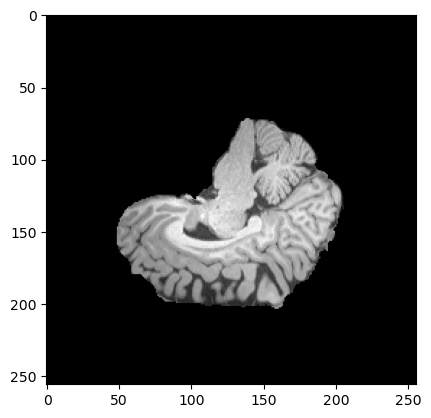

In [361]:
data = epi_img_data[100, :, :]
min_val = np.min(data)
max_val = np.max(data)
if np.unique(data).size > 1:
    normalized_data = (data - min_val) / (max_val - min_val) * 256
normalized_data = np.rot90(normalized_data, k=-1)
plt.imshow(normalized_data, cmap='gray')
plt.show()

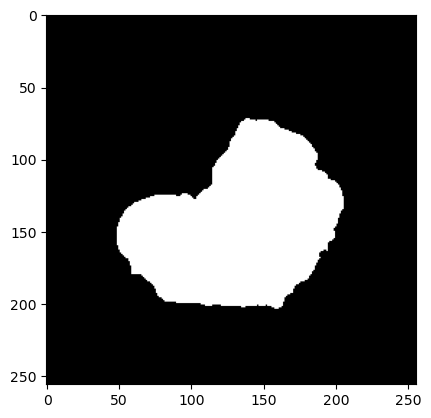

In [362]:
_, binary_image = cv.threshold(normalized_data, 1, 255, cv.THRESH_BINARY)
binary_image = binary_image > 0
plt.imshow(binary_image, cmap='gray')
plt.show()

In [363]:
structuring_element_l = np.array([
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]
    ], dtype=bool)

structuring_element_s = np.array([
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]
    ], dtype=bool)

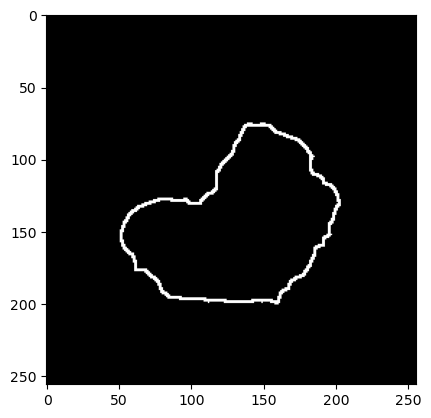

In [364]:
first_erosion = skimage.morphology.binary_erosion(binary_image, structuring_element_l)
second_erosion = skimage.morphology.binary_erosion(first_erosion, structuring_element_l)

boundary = np.bitwise_xor(first_erosion, second_erosion) 
plt.imshow(boundary, cmap='gray')
plt.show()

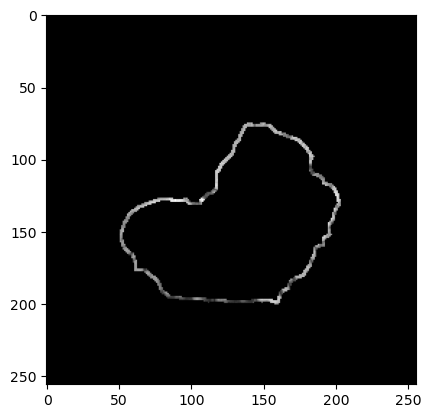

In [365]:
binary_mask = boundary.astype(data.dtype)
resulting_image = np.where(binary_mask, normalized_data, 0)

plt.imshow(resulting_image, cmap='gray')
plt.show()

## Brain construction functions

In [366]:
def create_point_cloud(image, z_value, threshold=5/255.0):
    height, width = image.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))  # Create a meshgrid of image coordinates
    z = np.full_like(x, z_value)  # Create a z-coordinate array with the given z_value
    
    # Flatten the arrays and stack them together
    points = np.stack((x.flatten(), y.flatten(), z.flatten()), axis=-1)
    colors = np.tile(image.flatten()[:, None], (1, 3))

    # Apply threshold to filter out points with a grayscale value of 5 or lower
    mask = image.flatten() > threshold
    points = points[mask]
    colors = colors[mask]
    
    return points, colors

In [367]:
points = np.empty((0, 3))
colors = np.empty((0, 3))

for i in range(epi_img_data.shape[0]):
    data = epi_img_data[:, i, :]
    min_val = np.min(data)
    max_val = np.max(data)
    if np.unique(data).size > 1:
        normalized_data = (data - min_val) / (max_val - min_val) * 256
    else:
        normalized_data = data
    normalized_data = np.rot90(normalized_data, k=-1)
    _, binary_image = cv.threshold(normalized_data, 5, 255, cv.THRESH_BINARY)
    binary_image = binary_image > 0

    first_erosion = skimage.morphology.binary_erosion(binary_image, structuring_element_l)
    second_erosion = skimage.morphology.binary_erosion(first_erosion, structuring_element_l)
    boundary = np.bitwise_xor(first_erosion, second_erosion) 
    
    binary_mask = boundary.astype(data.dtype)
    resulting_image = np.where(binary_mask, normalized_data, 0)
    resulting_image = resulting_image / 255.0
    
    point, color = create_point_cloud(resulting_image, i, 5 / 255.0)
    points = np.concatenate((points, point))
    colors = np.concatenate((colors, color))

In [368]:
# Create the Open3D point cloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)
print(pcd)
# o3d.visualization.draw_geometries([pcd])

PointCloud with 127292 points.


## Surface Reconstruction

In [369]:
# Estimate normals
pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(100)

In [370]:
print('run Poisson surface reconstruction')
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=11)
print(mesh)

run Poisson surface reconstruction
TriangleMesh with 204580 points and 409156 triangles.


In [371]:
# o3d.visualization.draw_geometries([mesh])

## saving files

In [372]:
np.save(f'constructions/sub_00{subject_id}/sub-00{subject_id}_points.npy', points)
np.save(f'constructions/sub_00{subject_id}/sub-00{subject_id}_colors.npy', colors)
o3d.io.write_point_cloud(f'constructions/sub_00{subject_id}/sub-00{subject_id}.ply', pcd)
o3d.io.write_triangle_mesh(f'constructions/sub_00{subject_id}/sub-00{subject_id}_mesh.obj', mesh)

[Open3D WARNING] Write Ply clamped color value to valid range


True